In [1]:
code_dir = "/home/mlmi-2020/jz522/localisation_from_image_project/code_reg_and_clas"
import os, sys
if code_dir not in sys.path:
    sys.path.append(code_dir)
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import seaborn as sns
import itertools

# util FUNCTIONS

In [10]:
def whiten(X, fudge=1E-18):
    " X - are all coords from the same region " 

    mean = np.mean(X, axis=0) # dim=3
    std  = np.std(X, axis=0)  # dim=3
    
    X = (X - mean) / std
    
    return X, mean, std

# Load scene coordinate data

In [4]:
data_dir = "/data/cornucopia/jz522/localisation_project/DS_003_JDB-Full/coordinates_256_512/"

In [5]:
data_size = 370
images = np.zeros((data_size, 256, 512, 3), dtype=np.float32)
scene_coords = np.zeros((data_size, 256, 512, 3), dtype=np.float32)

for data in tqdm(range(data_size)):
    coord_npz = f"{data+1:04}_rendered.png_config.npz"
    npz_data = np.load(data_dir + coord_npz)
    
    images[data,:,:,:] = npz_data['image_colors'] / 255.
    scene_coords[data,:,:,:] = npz_data['points_3d_world'] 


100%|██████████| 370/370 [03:19<00:00,  1.85it/s]


# Get 200 cluster centers

In [6]:
all_coords_flat = np.reshape(scene_coords, (-1,3))

### get cluster centers evenly spaced throughout the space

In [7]:
# get dimension range
x_min, x_max = all_coords_flat[:,0].min(), all_coords_flat[:,0].max()
y_min, y_max = all_coords_flat[:,1].min(), all_coords_flat[:,1].max()
z_min, z_max = all_coords_flat[:,2].min(), all_coords_flat[:,2].max()
print(x_min, x_max)
print(y_min, y_max)
print(z_min, z_max)

# get how many points to get for a dimension (3D) grid
num_regions = 1000
points_per_dim = int(np.ceil(np.cbrt(num_regions)))

# get cluster centers
x_centers = [x_min + (0.5+n)*(x_max - x_min)/points_per_dim for n in range(points_per_dim)]
y_centers = [y_min + (0.5+n)*(y_max - y_min)/points_per_dim for n in range(points_per_dim)]
z_centers = [z_min + (0.5+n)*(z_max - z_min)/points_per_dim for n in range(points_per_dim)]

# make a list of 3D cluster points
region_centers = np.array([[x,y,z] for x in x_centers for y in y_centers for z in z_centers])
region_centers = np.transpose(region_centers)
region_centers = np.expand_dims(region_centers, axis=0)
region_centers.shape

-10.3203125 16.546875
-3.0878906 29.78125
-6.15625 14.1328125


(1, 3, 1000)

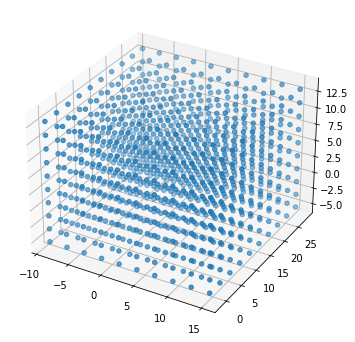

In [8]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(region_centers[0,0,:], region_centers[0,1,:], region_centers[0,2,:])

### compute euclidean distance of every point to each cluster 

In [9]:
point_cluster = np.zeros((all_coords_flat.shape[0]))
step = 100000

for ind in tqdm(np.arange(0, all_coords_flat.shape[0], step)):
    
    euclidean_distances = np.repeat(all_coords_flat[ind:ind+step, :, None], region_centers.shape[-1], axis=2)
    euclidean_distances = np.power(euclidean_distances - region_centers,2)
    euclidean_distances = np.mean(euclidean_distances, axis=1)
    
    point_cluster[ind:ind+step] = np.argmin(euclidean_distances, axis=-1)

100%|██████████| 485/485 [39:37<00:00,  4.90s/it]


In [12]:
point_cluster.shape

(48496640,)

**remove labels which have no points**

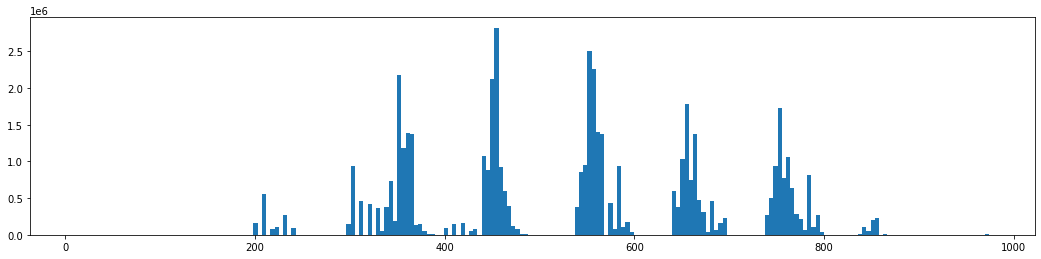

302


In [11]:
plt.figure(figsize=(18,4))
plt.hist(point_cluster, bins=216)
plt.show()

print(len(np.unique(point_cluster)))

### some categories got no points - remove those dimensions

In [12]:
num_clusters = len(np.unique(point_cluster))
num_data_points = point_cluster.shape[0]
point_clusters_tight = np.zeros((num_data_points))

for new_ind, old_ind in tqdm(enumerate(np.unique(point_cluster))):
    indeces = np.where(point_cluster == old_ind)
    point_clusters_tight[indeces] = new_ind

302it [00:11, 26.32it/s]


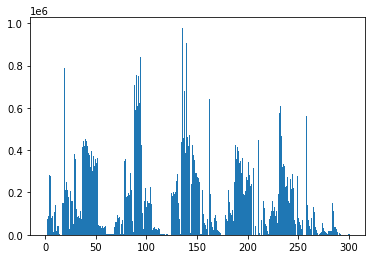

In [13]:
plt.hist(point_clusters_tight, bins=num_clusters)
plt.show()

### count points per cluster

In [14]:
point_clusters_tight = point_clusters_tight.astype(int)

In [15]:
num_of_points_per_cluster = np.zeros(len(np.unique(point_clusters_tight)))
small_clusters = 0

for i in tqdm(np.unique(point_clusters_tight)):
    amount = np.sum(point_clusters_tight == i)
    num_of_points_per_cluster[i] = amount
    if amount < 100000:
        small_clusters +=1
    
print(small_clusters)

100%|██████████| 302/302 [00:19<00:00, 15.63it/s]

161


### remove categories with less then 100,000 points

In [16]:
region_centers.shape

(1, 3, 1000)

In [17]:
cluster_centers = region_centers[0,:,np.unique(point_cluster).astype(int)]
cluster_centers.shape

(302, 3)

In [18]:
point_clusters_tight_2 =  np.zeros(point_cluster.shape[0])

In [19]:
point_clusters_tight_2.shape

(48496640,)

In [20]:
def get_clossest_cluster(i, current_center, cluster_centers):
    " get closes cluster with at least N points "
    
    distances = np.mean(np.power(cluster_centers - current_center, 2), axis=-1)
    sorted_clusters = np.argsort(distances)
    ind = 1
    
    while num_of_points_per_cluster[sorted_clusters[ind]] < 100000:
        ind +=1
        
    return sorted_clusters[ind]

In [21]:
for i in tqdm(range(num_clusters)):
    closest_cluster = i
    indeces = np.where(point_clusters_tight == i)
    
    if num_of_points_per_cluster[i] < 100000:    
        current_center = cluster_centers[i,:]
        closest_cluster = get_clossest_cluster(i, current_center, cluster_centers)
        
    point_clusters_tight_2[indeces] = closest_cluster

100%|██████████| 302/302 [00:12<00:00, 24.01it/s]


In [22]:
len(np.unique(point_clusters_tight_2))

141

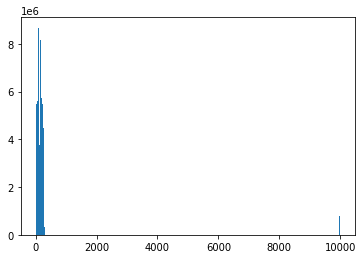

In [26]:
plt.hist(point_clusters_tight_2, bins=num_clusters)
plt.show()

### get mask -> cluster all masked points in one class 10000 (something large)

In [24]:
scene_coords_summed = np.sum(scene_coords, axis=-1)
mask = np.where(scene_coords_summed == 0, 0, 1).astype(bool)
mask_flat = np.reshape(mask, (-1))
mask_flat.shape

(48496640,)

In [25]:
point_clusters_tight_2[mask_flat == False] = 10000

### some categories got no points - remove those dimensions

In [27]:
num_clusters = len(np.unique(point_clusters_tight_2))
num_data_points = point_clusters_tight_2.shape[0]
point_clusters_tight_3 = np.zeros((num_data_points))

for new_ind, old_ind in tqdm(enumerate(np.unique(point_clusters_tight_2))):
    indeces = np.where(point_clusters_tight_2 == old_ind)
    point_clusters_tight_3[indeces] = new_ind

141it [00:05, 25.62it/s]


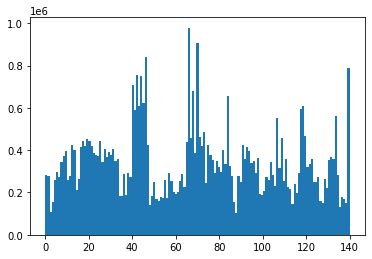

In [28]:
plt.hist(point_clusters_tight_3, bins=num_clusters)
plt.show()

In [29]:
for i in np.unique(point_clusters_tight_3):
    amount = np.sum(point_clusters_tight_3 == i)
    print(f"#{i}: ", amount)

#0.0:  282803
#1.0:  277726
#2.0:  106239
#3.0:  157228
#4.0:  260247
#5.0:  297184
#6.0:  271311
#7.0:  344227
#8.0:  373986
#9.0:  398223
#10.0:  260025
#11.0:  277724
#12.0:  425667
#13.0:  400715
#14.0:  213504
#15.0:  265149
#16.0:  414509
#17.0:  441988
#18.0:  418570
#19.0:  452962
#20.0:  444381
#21.0:  420437
#22.0:  385165
#23.0:  377451
#24.0:  370230
#25.0:  441833
#26.0:  344438
#27.0:  403911
#28.0:  367702
#29.0:  390781
#30.0:  379502
#31.0:  407088
#32.0:  347595
#33.0:  360574
#34.0:  184651
#35.0:  183644
#36.0:  286936
#37.0:  186450
#38.0:  290502
#39.0:  273979
#40.0:  706448
#41.0:  590106
#42.0:  754680
#43.0:  607102
#44.0:  751898
#45.0:  622469
#46.0:  841849
#47.0:  424820
#48.0:  141322
#49.0:  185012
#50.0:  250556
#51.0:  167866
#52.0:  161965
#53.0:  179211
#54.0:  174735
#55.0:  259119
#56.0:  173678
#57.0:  290101
#58.0:  253727
#59.0:  204039
#60.0:  193779
#61.0:  203569
#62.0:  252164
#63.0:  285824
#64.0:  225109
#65.0:  441024
#66.0:  979042
#67.0

In [99]:
point_clusters_tight_3 = point_clusters_tight_3.astype(int)

In [32]:
print('number of masked coords: ')
print(len(mask_flat) - np.sum(mask_flat))

number of masked coords: 
788611


# Whiten scene_coords

In [33]:
n = len(np.unique(point_clusters_tight_3))
n

141

In [36]:
std_vec = np.zeros((n,3))
mean_vec = np.zeros((n,3))

### deal with all non-masked coords (note: n-1)

In [37]:
all_coords_scene_back_flat = np.zeros((all_coords_flat.shape[0], 3))
all_coords_local_flat = np.zeros((all_coords_flat.shape[0], 3))

for i in tqdm(range(n-1)):
    
    indexes_class = np.where(point_clusters_tight_3 == i, True, False)
    class_coords = all_coords_flat[indexes_class]
    
    local_class_coords, mean, std = whiten(class_coords)
    
    all_coords_local_flat[indexes_class] = local_class_coords

    # check
    all_coords_scene_back_flat[indexes_class] = (all_coords_local_flat[indexes_class] * std) + mean
    
    mean_vec[i] = mean
    std_vec[i] = std
    
all_coords_local = np.reshape(all_coords_local_flat, (370,256,512,3))
all_coords_scene_back = np.reshape(all_coords_scene_back_flat, (370,256,512,3))

100%|██████████| 140/140 [01:27<00:00,  1.61it/s]


# deal with the masked category (last index)

In [40]:
mean_vec[-1] = [0,0,0]
std_vec[-1] = [1,1,1]

In [41]:
std_vec[-2:]

array([[0.48543164, 0.73150408, 1.05407834],
       [1.        , 1.        , 1.        ]])

In [118]:
# important to correct NaN values for masked category
# all_coords_local_flat[mask_flat == False,:] = [0,0,0]

In [44]:
all_coords_local = np.reshape(all_coords_local_flat, (370,256,512,3))

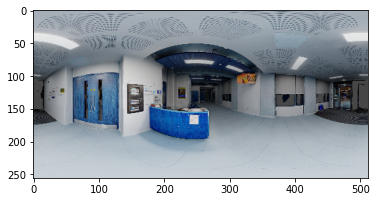

In [42]:
plt.imshow(images[10])

In [55]:
print('check sum squared error:')
np.sum(np.square(all_coords_scene_back[6] - scene_coords[6]))

check sum squared error:


2.4219419676518796e-10

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


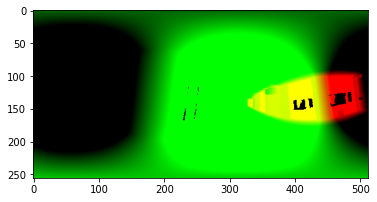

In [43]:
plt.imshow(all_coords_scene_back[6])

In [49]:
point_regions = np.reshape(point_clusters_tight_3, (370,256,512))

# What do I want in my new .npz data file?:
* HAVE image_colors
* HAVE bearings
* HAVE scene_coordinates
* HAVE mask
* coord_region_labels
* local_scene_coordinates
* coord_region_centers

In [52]:
# "simple whitenning" means: mean=0 variance=1 (covariances are not decorelated)
dir_to_save = "/data/cornucopia/jz522/localisation_project/DS_003_JDB-Full/coordinates_256_512__141_classes__simple_whitening/"
data_dir = "/data/cornucopia/jz522/localisation_project/DS_003_JDB-Full/coordinates_256_512/"

if not os.path.exists(dir_to_save):
    os.makedirs(dir_to_save)
    

for ind in tqdm(range(370)):
    npz_file_name = f"{ind+1:04}_rendered.png_config.npz" 
    npz_data = np.load(data_dir + npz_file_name)
      
    np.savez(dir_to_save + npz_file_name, 
             image_colors = npz_data['image_colors'] / 255., 
             points_3d_world = npz_data['points_3d_world'], 
             points_3d_sphere = npz_data['points_3d_sphere'], 
             R_blender = npz_data['R_blender'], 
             T_blender = npz_data['T_blender'], 
             mask = mask[ind], 
             points_region_class = point_regions[ind], 
             local_scene_coords = all_coords_local[ind],
             mean_vec = mean_vec,
             std_vec = std_vec)

100%|██████████| 370/370 [10:40<00:00,  1.73s/it]


# Load data - check

In [56]:
ind = 0
npz_file_name = f"{ind+1:04}_rendered.png_config.npz"
npz_data = np.load(dir_to_save + npz_file_name)
npz_data.files

['image_colors',
 'points_3d_world',
 'points_3d_sphere',
 'R_blender',
 'T_blender',
 'mask',
 'points_region_class',
 'local_scene_coords',
 'mean_vec',
 'std_vec']

### check: img colors 

In [57]:
npz_data['image_colors'].max()

0.9098039215686274

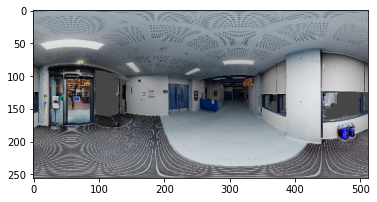

In [58]:
plt.imshow(npz_data['image_colors'])
plt.show()

### check: scene coords

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


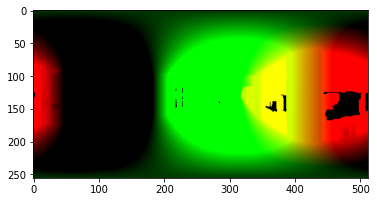

In [59]:
plt.imshow(npz_data['points_3d_world'])
plt.show()

### check: mask

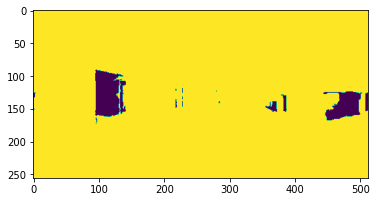

In [60]:
plt.imshow(npz_data['mask'])
plt.show()

### check: points_region_class

In [61]:
np.unique(npz_data['points_region_class'])

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  16.,  24.,  25.,  32.,  33.,  40.,  49.,  50.,
        57.,  58.,  84., 112., 117., 140.])

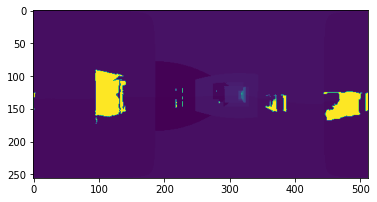

In [62]:
plt.imshow(npz_data['points_region_class'])
plt.show()

### check: local_scene_coords

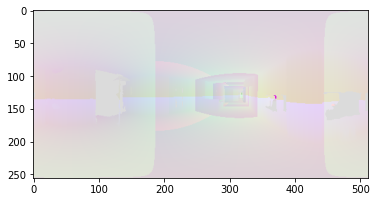

In [63]:
tmp = (npz_data['local_scene_coords'] - npz_data['local_scene_coords'].min()) / (npz_data['local_scene_coords'].max() - npz_data['local_scene_coords'].min())
plt.imshow(tmp)

### check: W_inv and M

In [65]:
npz_data['std_vec'][0]

array([0.69238383, 0.9933328 , 0.36111701])

In [66]:
npz_data['mean_vec'][0]

array([-3.27600789,  1.78426409, -5.30658531])

In [68]:
npz_data['std_vec'].shape

(141, 3)

In [69]:
npz_data['mean_vec'].shape

(141, 3)